In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
x_train = np.load('data/x_train_undersampled.npy')
y_train = np.load('data/y_train_undersampled.npy')
x_test = np.load('data/x_test_undersampled.npy')
y_test = np.load('data/y_test_undersampled.npy')
y_train2 = np.load('data/y_train_undersampled_dataset.npy')
y_test2 = np.load('data/y_test_undersampled_dataset.npy')

In [3]:
print(x_train.shape)
print(x_test.shape)

(5010, 224, 224, 3)
(300, 224, 224, 3)


In [4]:
print(y_train.shape)
print(y_test.shape)

(5010,)
(300,)


In [5]:
print(y_train2.shape)
print(y_test2.shape)

(5010,)
(300,)


In [6]:
from __future__ import print_function

import numpy as np
from random import shuffle
import time
import csv
from PIL import Image
import os
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import initializers
from keras.optimizers import SGD
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import *
from keras.callbacks import CSVLogger
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import sklearn.metrics as sklm
import sys
sys.path.insert(0,'..')
from utils import lossprettifier
from Classifier.VGG_two_outputs_v2 import *

C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\tensorflow\python\f

In [7]:
# for reproducibility
np.random.seed(3768)

# use this environment flag to change which GPU to use 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

#Get TensorFlow session
def get_session(): 
  config = tf.ConfigProto() 
  config.gpu_options.allow_growth = True 
  return tf.Session(config=config) 
  
# One hot encoding of labels 
def dense_to_one_hot(labels_dense,num_clases=3):
  return np.eye(num_clases)[labels_dense]

In [8]:
# Preparing training and test sets
x_train_tmp, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42)
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(x_train, y_train2, test_size=0.10, random_state=42)

In [9]:
x_train = x_train_tmp

In [10]:
y_train = dense_to_one_hot(y_train,num_clases=3)
y_valid = dense_to_one_hot(y_valid,num_clases=3)
y_train2 = dense_to_one_hot(y_train2,num_clases=5)
y_valid2 = dense_to_one_hot(y_valid2,num_clases=5)

In [11]:
#Image data generation for the training 
datagen = ImageDataGenerator(
               featurewise_center = False, 
               samplewise_center = False,  # set each sample mean to 0
               featurewise_std_normalization = True,  
               samplewise_std_normalization = False)  

datagen.fit(x_train) 
for i in range(len(x_test)):
      x_test[i] = datagen.standardize(x_test[i])

C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\keras_preprocessing\image\image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [12]:
#Defining hyperparameters
batch_Size = 32
steps_Per_Epoch = 32
numEpochs = 50

#Instantating VGG19 model
model = VGG19((224,224,3),classes=[3, 5]) #VGG19_dense for revised VGG19, VGG19 for VGG19. Please pay attention to VGG16(), chnage the input shape and class number in VGG.py.

#Creating an optimizers
adaDelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer = sgd , loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Creating early stopping 
earlystop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 50, verbose = 1, mode = 'auto', restore_best_weights = True)       

In [13]:
def make_multi_output_flow(image_gen, X, y_list, batch_size):
    y_item_0 = y_list[0]
    y_indices = np.arange(y_item_0.shape[0])
    orig_flow = image_gen.flow(X, y=y_indices, batch_size=batch_size)

    while True:
        (X, y_next_i) = next(orig_flow)
        y_next = [ y_item[y_next_i] for y_item in y_list ]
        yield X, y_next

y_train_gen = [y_train, y_train2]
train_generator = make_multi_output_flow(datagen, x_train, y_train_gen, batch_Size)

y_valid_gen = [y_valid, y_valid2]
validation_generator = make_multi_output_flow(datagen, x_valid, y_valid_gen, batch_Size)
        
#train_generator = datagen.flow(x_train, y_train, batch_size = batch_Size)
#validation_generator = datagen.flow(x_valid, y_valid, batch_size = batch_Size)

In [14]:
class_weight = [{0: 1, 1: 1, 2: 1},{0: 1, 1: 3, 2: 7, 3:50, 4:50}]

In [15]:
# Model training
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_Per_Epoch,
    validation_data = validation_generator, 
    validation_steps = 16,
    epochs = numEpochs,
    shuffle = True, 
    verbose = 1,
    class_weight=class_weight)


Epoch 1/50
32/32 [==============================] - 5s 169ms/step - loss: 4.9414 - predictions_loss: 1.0911 - predictions_branch_loss: 3.8504 - predictions_accuracy: 0.3623 - predictions_branch_accuracy: 0.2324 - val_loss: 2.3871 - val_predictions_loss: 1.0474 - val_predictions_branch_loss: 1.3241 - val_predictions_accuracy: 0.5629 - val_predictions_branch_accuracy: 0.0938
Epoch 2/50
32/32 [==============================] - 2s 56ms/step - loss: 4.5292 - predictions_loss: 0.9940 - predictions_branch_loss: 3.5352 - predictions_accuracy: 0.5078 - predictions_branch_accuracy: 0.2646 - val_loss: 2.1192 - val_predictions_loss: 0.9103 - val_predictions_branch_loss: 1.2144 - val_predictions_accuracy: 0.6008 - val_predictions_branch_accuracy: 0.2515
Epoch 3/50
32/32 [==============================] - 2s 57ms/step - loss: 5.0410 - predictions_loss: 0.8980 - predictions_branch_loss: 4.1430 - predictions_accuracy: 0.5957 - predictions_branch_accuracy: 0.3096 - val_loss: 2.3079 - val_predictions_l

32/32 [==============================] - 2s 55ms/step - loss: 4.4911 - predictions_loss: 0.7194 - predictions_branch_loss: 3.7718 - predictions_accuracy: 0.6924 - predictions_branch_accuracy: 0.1729 - val_loss: 1.8913 - val_predictions_loss: 0.6724 - val_predictions_branch_loss: 1.2918 - val_predictions_accuracy: 0.7146 - val_predictions_branch_accuracy: 0.2515
Epoch 23/50
32/32 [==============================] - 2s 56ms/step - loss: 4.5761 - predictions_loss: 0.6510 - predictions_branch_loss: 3.9251 - predictions_accuracy: 0.7169 - predictions_branch_accuracy: 0.2527 - val_loss: 1.9252 - val_predictions_loss: 0.6345 - val_predictions_branch_loss: 1.3710 - val_predictions_accuracy: 0.7305 - val_predictions_branch_accuracy: 0.2515
Epoch 24/50
32/32 [==============================] - 2s 56ms/step - loss: 4.5769 - predictions_loss: 0.6883 - predictions_branch_loss: 3.8887 - predictions_accuracy: 0.7227 - predictions_branch_accuracy: 0.2959 - val_loss: 1.9941 - val_predictions_loss: 0.5822

Epoch 44/50
32/32 [==============================] - 2s 56ms/step - loss: 4.4872 - predictions_loss: 0.6203 - predictions_branch_loss: 3.8669 - predictions_accuracy: 0.7383 - predictions_branch_accuracy: 0.2520 - val_loss: 1.8027 - val_predictions_loss: 0.5982 - val_predictions_branch_loss: 1.2666 - val_predictions_accuracy: 0.7685 - val_predictions_branch_accuracy: 0.6467
Epoch 45/50
32/32 [==============================] - 2s 56ms/step - loss: 4.8422 - predictions_loss: 0.5897 - predictions_branch_loss: 4.2524 - predictions_accuracy: 0.7571 - predictions_branch_accuracy: 0.3124 - val_loss: 1.8079 - val_predictions_loss: 0.5885 - val_predictions_branch_loss: 1.4262 - val_predictions_accuracy: 0.7764 - val_predictions_branch_accuracy: 0.2515
Epoch 46/50
32/32 [==============================] - 2s 56ms/step - loss: 4.3838 - predictions_loss: 0.5529 - predictions_branch_loss: 3.8310 - predictions_accuracy: 0.7764 - predictions_branch_accuracy: 0.1475 - val_loss: 2.0603 - val_predictions_

In [16]:
modelPath = "VGG19_COVID19-v2.h5"
resultPath = 'VGG19_COVID19-v2.txt'
modelsavePath = 'VGG19_COVID19-v2_MODEL'

In [17]:
y_test_oh = dense_to_one_hot(y_test, num_clases=3)
y_test_oh2 = dense_to_one_hot(y_test2, num_clases=5)

# visualizing losses and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']

#Observing the losses but can be commented out as it's not mandatory 
reporter = lossprettifier.LossPrettifier(show_percentage=True)

for i in range(numEpochs-1):
    reporter(epoch=i, LossA = train_loss[i], LossAB = val_loss[i])

Epoch     0 | LossA: 4.94(+0.00%) 	| LossAB: 2.39(+0.00%) 	
Epoch     1 | LossA: 4.53(-8.34%) ▼	| LossAB: 2.12(-11.22%) ▼	
Epoch     2 | LossA: 5.04(+11.30%) ▲	| LossAB: 2.31(+8.90%) ▲	
Epoch     3 | LossA: 4.75(-5.75%) ▼	| LossAB: 2.18(-5.58%) ▼	
Epoch     4 | LossA: 5.06(+6.47%) ▲	| LossAB: 1.94(-11.09%) ▼	
Epoch     5 | LossA: 4.26(-15.81%) ▼	| LossAB: 2.23(+14.87%) ▲	
Epoch     6 | LossA: 4.59(+7.89%) ▲	| LossAB: 2.34(+5.32%) ▲	
Epoch     7 | LossA: 4.68(+1.86%) ▲	| LossAB: 2.08(-11.05%) ▼	
Epoch     8 | LossA: 5.26(+12.38%) ▲	| LossAB: 2.07(-0.66%) ▼	
Epoch     9 | LossA: 4.53(-13.81%) ▼	| LossAB: 1.88(-9.02%) ▼	
Epoch    10 | LossA: 4.27(-5.81%) ▼	| LossAB: 1.86(-1.44%) ▼	
Epoch    11 | LossA: 4.89(+14.43%) ▲	| LossAB: 2.24(+20.55%) ▲	
Epoch    12 | LossA: 4.60(-5.80%) ▼	| LossAB: 2.23(-0.26%) ▼	
Epoch    13 | LossA: 4.96(+7.80%) ▲	| LossAB: 2.08(-7.02%) ▼	
Epoch    14 | LossA: 4.51(-9.17%) ▼	| LossAB: 2.20(+5.97%) ▲	
Epoch    15 | LossA: 4.73(+4.85%) ▲	| LossAB: 2.30(+4.35%) ▲	


In [18]:
# Model evaluation 
loss, main_loss, aux_loss, main_acc, aux_acc = model.evaluate(x_test, [y_test_oh, y_test_oh2], batch_size=batch_Size)
print("Accuracy:", main_acc)
print("Branch Accuracy:", aux_acc)

#if acc>0.675:
model.save_weights(modelPath)
model.save(modelsavePath)

300/300 [==============================] - 0s 2ms/step
Accuracy: 0.7866666913032532
Branch Accuracy: 0.05666666850447655


In [19]:
y_pred, y_pred2 = model.predict(x_test)
y_pred = y_pred.reshape(len(y_test), 3)
y_pred2 = y_pred2.reshape(len(y_test2), 5)
y_pred = np.argmax(y_pred, axis=1)
y_pred2 = np.argmax(y_pred2, axis=1)

#Print class-wise classification metrics
print(classification_report(y_test, y_pred))
print("------------------------------------")
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.87      0.77      0.81       100
           1       0.76      0.78      0.77       100
           2       0.75      0.81      0.78       100

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300

------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       198
           1       0.06      1.00      0.11        17
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00        11

    accuracy                           0.06       300
   macro avg       0.01      0.20      0.02       300
weighted avg       0.00      0.06      0.01       300



C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Anaconda3\envs\wbvenv36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


oryginalne


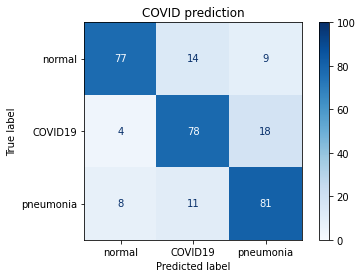

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("oryginalne")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['normal', 'COVID19', 'pneumonia']))
disp.plot(cmap='Blues') 
disp.ax_.set_title("COVID prediction")
disp.ax_.get_images()[0].set_clim(0, 100)

predykcja datasetu


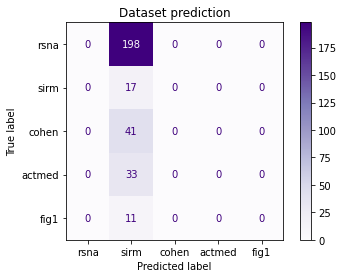

In [21]:
print("predykcja datasetu")
cm2 = confusion_matrix(y_test2, y_pred2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=np.array(['rsna', 'sirm', 'cohen', 'actmed', 'fig1']))
disp2.plot(cmap='Purples') 
disp2.ax_.set_title("Dataset prediction")
disp2.ax_.get_images()[0] #.set_clim(0, 100)